Run this tuning with PERMUTE=False and VIX=False. It affects the saving directory, but not the data used for tuning or results from tuning.

In [1]:
import sys
import os
# Append the library path to PYTHONPATH, so library can be imported.
sys.path.append(os.path.dirname(os.getcwd()))
import shutil
import datetime

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from library import plot
from library import network as nw
from library import common as cm

Using TensorFlow backend.


In [2]:
%run setup.py
%run Load_Clean_aux.py tune

seed = 666
np.random.seed(seed)

Loading Hyper Tuning data sets!

Load and clean the training and validation data.
Original data size is 412671
We remove in-the-money samples. 206541 samples (50.05%) are removed. We have 49.95% of original data left, yielding a size of 206130.
We shrink moneyness range. 150 samples (0.07%) are removed. We have 49.91% of original data left, yielding a size of 205980.
We remove samples when S1 is not available. 1705 samples (0.83%) are removed. We have 49.50% of original data left, yielding a size of 204275.


Clean and load all Monte Carlo test data.

Load Monte Carlo set 1
We remove in-the-money samples. 40542 samples (50.35%) are removed. We have 49.65% of original data left, yielding a size of 39984.
We shrink moneyness range. 12 samples (0.03%) are removed. We have 49.64% of original data left, yielding a size of 39972.
We remove samples when S1 is not available. 1168 samples (2.92%) are removed. We have 48.19% of original data left, yielding a size of 38804.


Load Monte Carlo set

In [4]:
if FEATURE_SET == 'normal_feature':
    ori_fea = ['M0', 'tau0_implvol0']
    sub_res = res_dir + 'Network/Normal_Feature/TuneHypers/'

if FEATURE_SET == 'delta_vega':
    ori_fea = ['delta_bs', '1_over_sqrt_tau', 'vega_n']
    sub_res = res_dir + 'Network/Delta_Vega/TuneHypers/'

if FEATURE_SET == 'delta_vega_vanna':
    ori_fea = ['delta_bs', '1_over_sqrt_tau', 'vega_n', 'vanna_n']
    sub_res = res_dir + 'Network/Delta_Vega_Vanna/'   
    
if VIX:
    ori_fea += ['fake_vix']

os.makedirs(sub_res, exist_ok=True)

In [5]:
df_val = df_train.loc[df_train['period0'] == 1].copy()
df_train = df_train.loc[df_train['period0'] == 0].copy()

##### Step 2: Standardize features
The training and validation set are standardized, and the resulting scaler shall be passed to standardize each Monte Carlo set later.

In [6]:
use_fea = [x + '_t' for x in ori_fea] + ['cp_int']

scaler = StandardScaler().fit(X=df_train[ori_fea])
df_train, df_val = nw.standardize_feature([df_train, df_val], scaler, ori_fea)

In [7]:
use_fea

['delta_bs_t', '1_over_sqrt_tau_t', 'vega_n_t', 'vanna_n_t', 'cp_int']

##### Step 3: Specify a candidate set
We need to specify a set of candidate hyperparameters. Each candidate will be used to train a new network for a specified number of times.

In [10]:
hypers = {
    'nodes_per_layer': (30, 30),
    'reg_alpha': 1e-4,
    'lr': 1e-4,
    'epochs': 300,
    'outact': 'linear'
}
lab_tune = 'reg_alpha'
value_set = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
num_run = 5 # 5

In [11]:
sub_res

'C:\\Users\\Weiguan\\Dropbox\\Research\\01_DeepHedging\\Data_OK\\BlackScholes/Result/CONFIG=1/FREQ=2D_HALFMONEY=otm_MINM=0.8_MAXM=1.5_Permute=False_VIX=False/Network/Delta_Vega_Vanna/'

##### Step 4: Training step


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 155785 samples, validate on 47674 samples
Epoch 1/3
155785/155785 [==============================] - 6s 38us/step - loss: 0.3906 - mean_squared_error: 0.0967 - val_loss: 0.2159 - val_mean_squared_error: 0.0084
Epoch 2/3
155785/155785 [==============================] - 5s 33us/step - loss: 0.1518 - mean_squared_error: 0.0091 - val_loss: 0.0957 - val_mean_squared_error: 0.0061
Epoch 3/3
155785/155785 [==============================] - 5s 33us/step - loss: 0.0661 - mean_squared_error: 0.0083 - val_loss: 0.0407 - val_mean_squared_error: 0.0059
Train on 155785 samples, validate on 47674 samples
Epoch 1/3
155785/155785 [==============================] - 6s 39us/step - loss: 0.3744 - mean_squared_error: 0.0857 - val_loss: 0.2039 - val_mean_squared_error: 0.0077
Epoch 2/3
155785/155785 [==============================] - 6s 39us/step - loss: 0.1442 - mean_squared_erro

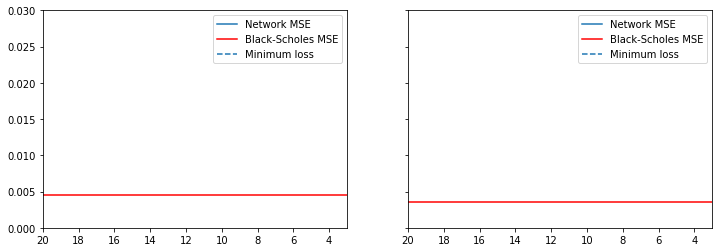

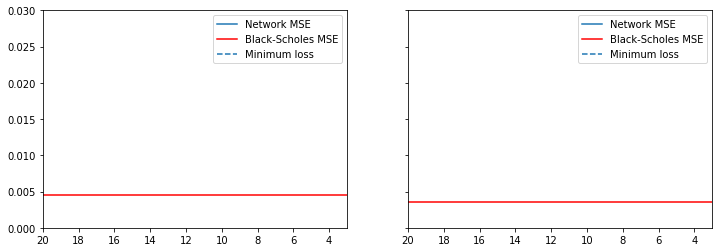

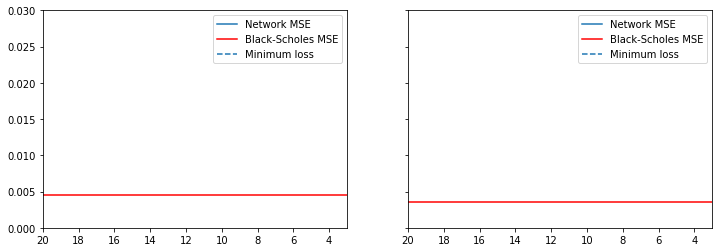

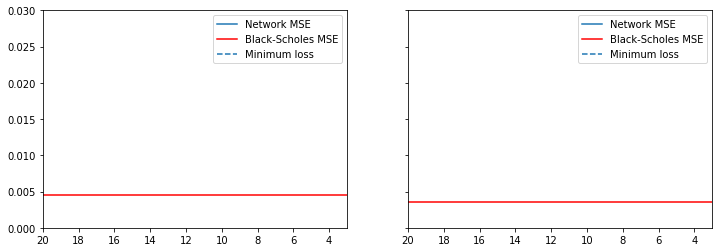

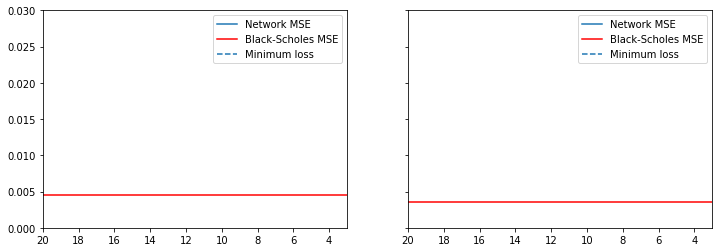

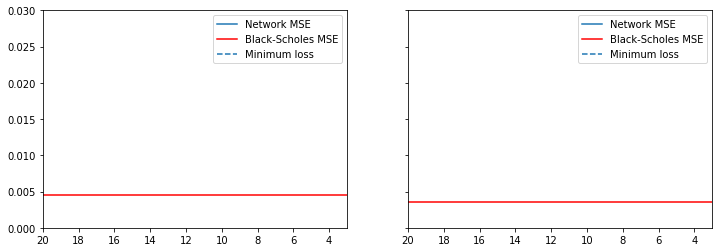

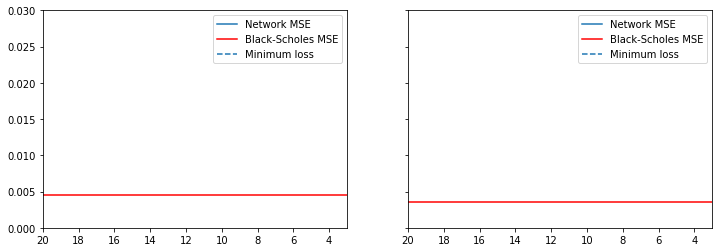

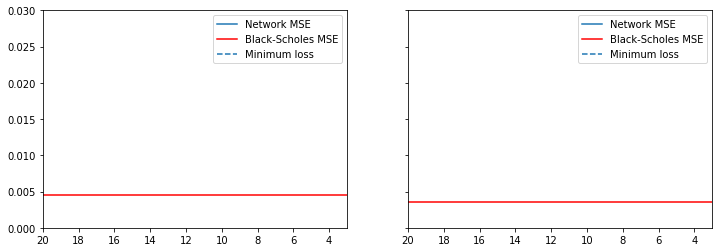

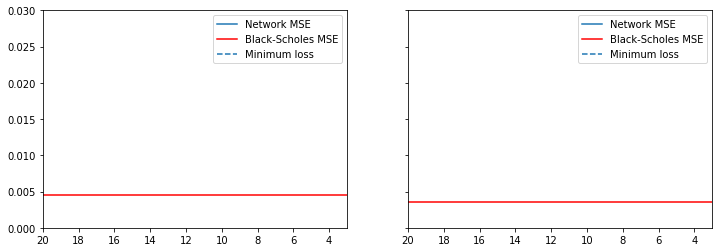

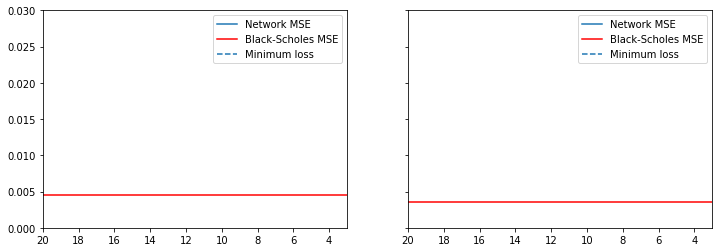

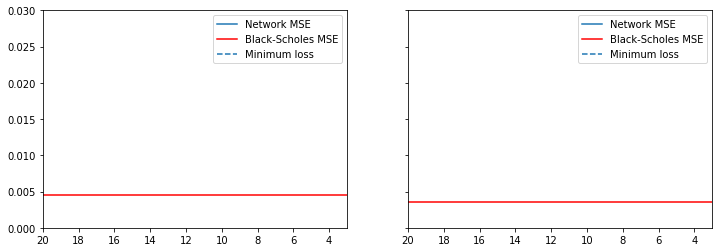

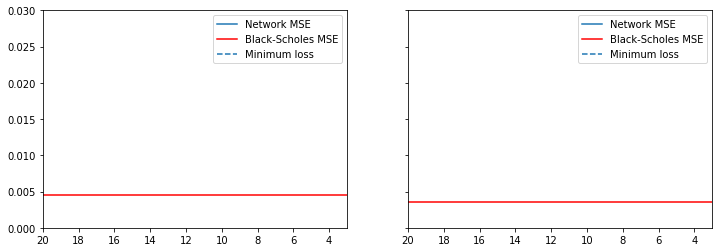

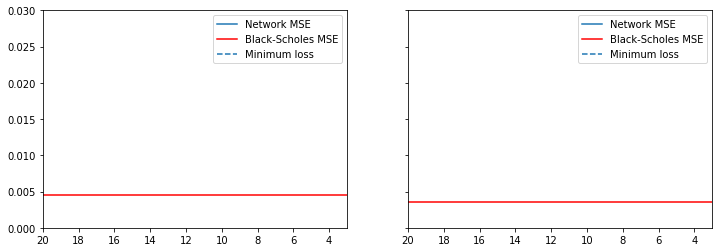

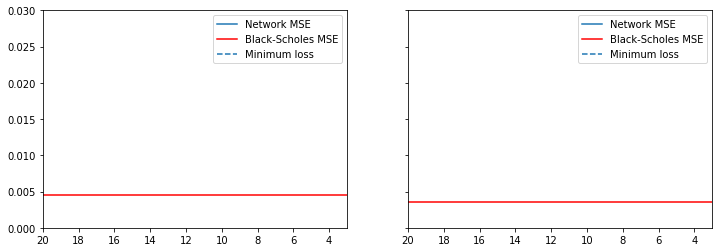

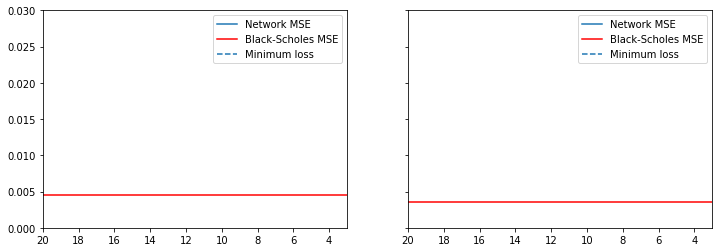

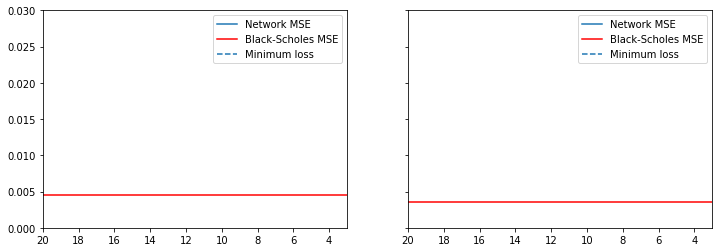

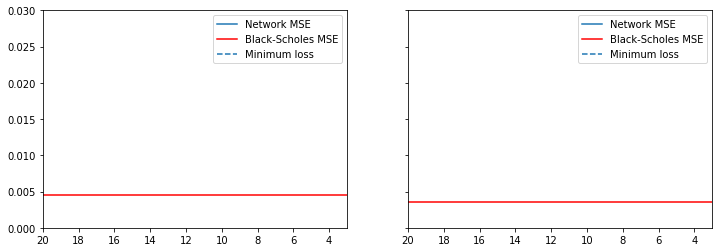

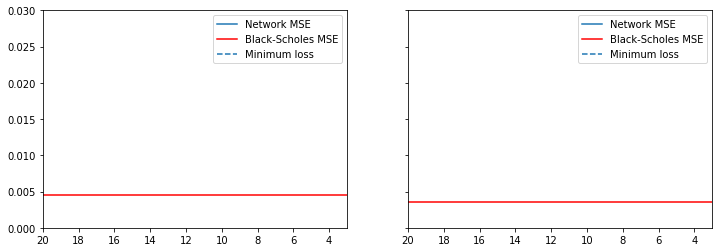

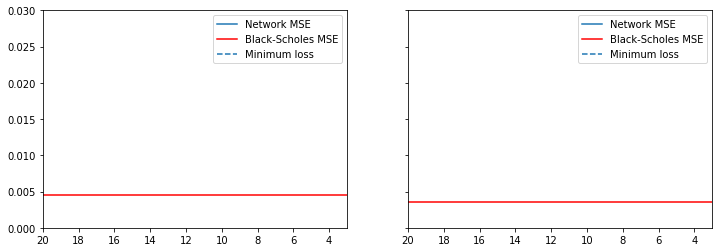

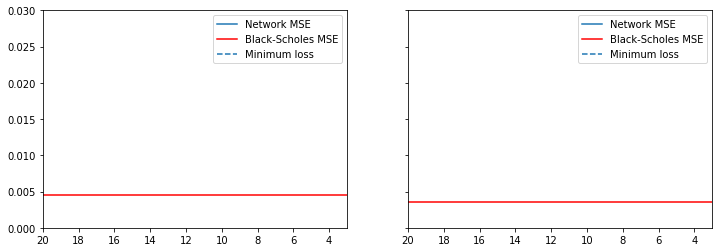

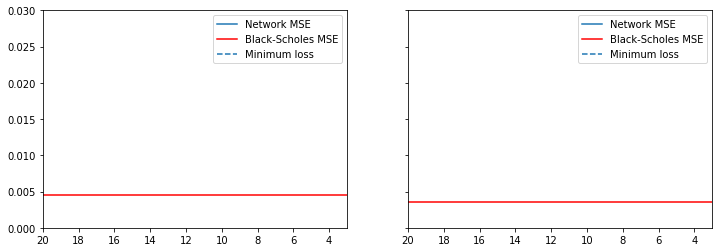

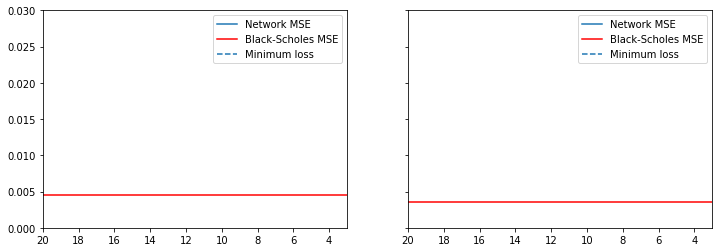

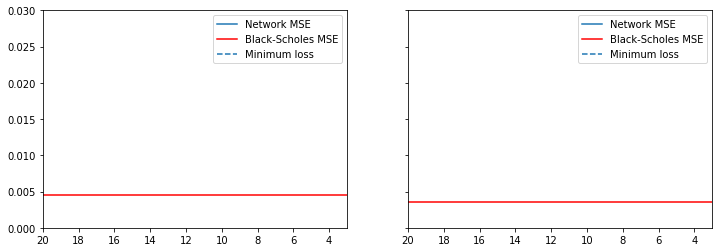

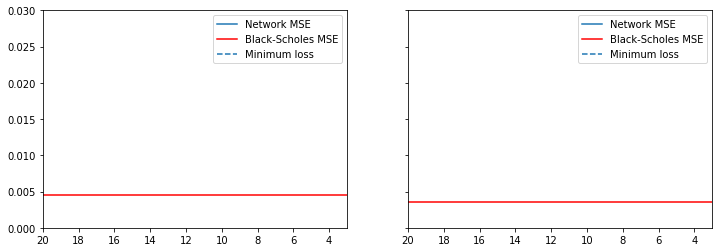

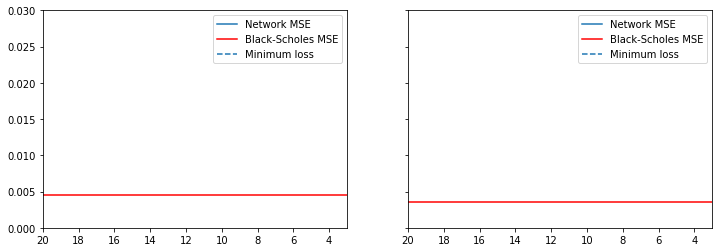

In [12]:
for value in value_set:
    # If you want to tune other hyper apart from alpha, 
    # change key name and directory name of the next two lines.
    hypers[lab_tune] = value
    alpha_dir = sub_res + f'para={value:.0e}/'
    
    alpha_dir_dict = {
        'ckp': alpha_dir + 'ckp/',
        'history': alpha_dir + 'history/',
        'metrics': alpha_dir + 'metrics/',
        'plot': alpha_dir + 'plot/'
    }
    for key, value in alpha_dir_dict.items():
        os.makedirs(value, exist_ok=True)
    
    # for each value, we train a (new) network multiple times.
    for i in range(num_run):   
        """
        Here, each checkpoint, history, and metrics corresponds to each run.
        """        
        # for each iteration, we record its performance on each of MC set.
        df_metrics = pd.DataFrame(index=range(NUM_TEST), columns=['BS', 'NN'])
        
        sub_res_paths = {
            'ckp': alpha_dir_dict['ckp'] + f'bestcp{i}.h5',
            'history': alpha_dir_dict['history'] + f'history{i}.csv',
            'plot': alpha_dir_dict['plot'] + f'losscurve{i}.png',
            'metrics': alpha_dir_dict['metrics'] + f'metrics{i}.csv'
        }
        history = nw.train_net_core(df_train, df_val, use_fea, hypers, sub_res_paths)
        nw.plot_history(history, sub_res_paths['plot'], df_train, df_val)
        
        """
        Each train is tested on many Monte Carlo sets.
        """
        for j in range(NUM_TEST):
            df_test = mc_sets[j].copy()
            [df_test] = nw.standardize_feature([df_test], scaler, ori_fea)
            
            delta_nn = nw.test_net_core(df_test, use_fea, sub_res_paths)
            
            """
            We calculate NN pnl and BS pnl.
            """
            pnl_nn = cm.calc_pnl(df_test, delta_nn)
            pnl_bs = cm.calc_pnl(df_test, df_test['delta_bs'])
            
            df_metrics.loc[j, 'NN'] = (pnl_nn**2).mean()
            df_metrics.loc[j, 'BS'] = (pnl_bs**2).mean()      
        
        df_metrics.to_csv(sub_res_paths['metrics'])

# Summarize tuning results
This section can be run independent of the above one, if the directory paths are given properly.

In [13]:
num_run = 5
value_set = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [14]:
df_metrics_summary = pd.DataFrame(
    index=range(num_run), 
    columns=['BS'] + [f'para={v:.0e}' for v in value_set])

In [15]:
for value in value_set:
    metrics_folder = sub_res + f'para={value:.0e}/metrics/'
    
    for i in range(num_run):
        df_metrics = pd.read_csv(metrics_folder + f'metrics{i}.csv', index_col=0)
        """
        'BS' errors do not change, whatever the alpha is.
        We take the average over all test sets for each run.
        """
        df_metrics_summary.loc[i, 'BS'] = df_metrics.mean()['BS'] 
        df_metrics_summary.loc[i, f'para={value:.0e}'] = df_metrics.mean()['NN']

df_metrics_summary = df_metrics_summary.astype('float32')

This summary table shows the average test metric over all the Monte Carlo data sets, for different hyperparamters and many runnings of network. 

In [16]:
df_metrics_summary.to_csv(f'{sub_res}individual_mc_performance.csv')

In [17]:
df_metrics_summary

,BS,para=1e-02,para=1e-03,para=1e-04,para=1e-05,para=1e-06
0,0.00434,0.007380,0.005070,0.004588,0.005273,0.004893
1,0.00434,0.007222,0.004947,0.004758,0.004866,0.005220
2,0.00434,0.006669,0.004755,0.004616,0.005204,0.004719
3,0.00434,0.007837,0.004732,0.004663,0.004609,0.004707
4,0.00434,0.008724,0.005409,0.004725,0.004996,0.004744


In [18]:
df_metrics_summary.describe().to_csv(f'{sub_res}summary_metrics.csv')

In [19]:
df_metrics_summary.describe()

,BS,para=1e-02,para=1e-03,para=1e-04,para=1e-05,para=1e-06
count,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.00434,0.007566,0.004982,0.004670,0.004990,0.004857
std,0.00000,0.000770,0.000276,0.000072,0.000268,0.000217
min,0.00434,0.006669,0.004732,0.004588,0.004609,0.004707
25%,0.00434,0.007222,0.004755,0.004616,0.004866,0.004719
50%,0.00434,0.007380,0.004947,0.004663,0.004996,0.004744
75%,0.00434,0.007837,0.005070,0.004725,0.005204,0.004893
max,0.00434,0.008724,0.005409,0.004758,0.005273,0.005220


# Save results
Run this section, if you want to save all related checkpoint, history and plots permanently, so that they will not be covered.

In [20]:
# Copy data setup file from the clean data folder, and then append network setup.
shutil.copy('setup.py', sub_res)

with open(f'{sub_res}tuning-setting.txt', 'w') as file:
    file.write('The following is TUNE setup.\n')
    file.write(f'Date and time = {datetime.datetime.now()}\n')
    for n, x in [
        ('Random seed', seed),
        ('Features used', use_fea),
        ('Hypers', hypers),
        ('Value set to tune from', value_set),
        ('Number of iterations', num_run)
    ]:
        file.write(f'{n} = {x}\n') 
    file.write(f'{lab_tune} is being tuned.')